## pyroomacoustics demo

在本脚本中，我们展示了一些有关`pyroomacoustics`的一些特性：

- （1）相关python类变成与方便的面向对象接口。
- （2）房间脉冲响应生成器（RIR，Room Impulse Response）。
- （3）相关算法设计

本脚本的演示示例列表：
- 1、创建一个2D/3D房间
- 2、添加声源和麦克风
- 3、RIR生成以及传播仿真（propagation simulation）
- 4、波束形成（Beamforming）
- 5、波达方向（Direction-of-Arrival）
- 6、自适应滤波（Adaptive filtering）
- 7、短时傅利叶转换（STFT）处理
- 8、源分离（Source Separation）

更多内容可以参考[Pyroomacoustics的Github仓库](https://github.com/LCAV/pyroomacoustics)或者参考[论文](https://arxiv.org/pdf/1710.04196.pdf)，引用格式如下所示：

R. Scheibler, E. Bezzam, I. Dokmanić, Pyroomacoustics: A Python package for audio room simulations and array processing algorithms, Proc. IEEE ICASSP, Calgary, CA, 2018.

In [1]:
# 倒入必要的软件包
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import IPython
import pyroomacoustics as pra

### 一、创建2D/3D房间

**注意：**
- 在定义房间的2D空间节点时候，需要<font color="red">注意其顺序</font>，否则不会出现预期的房间形状。
- <font color="red">在构建节点时候需要逆时针方向一次定义节点坐标</font>。

[[0 0 5 5 3 3]
 [0 3 3 1 1 0]]


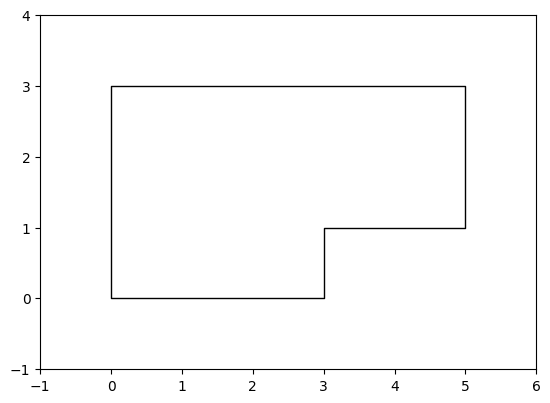

In [2]:
# 定义房间的二维空间节点
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T
print(corners)

# 由二维空间节点构造2D房间
room = pra.Room.from_corners(corners)
# print(type(room))   # 查看room的数据类型

# 绘制2的房间
fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

如果想要构建3D房间，我们可以将构建的2D房间拉伸一个特定的长度。

/home/liang/miniconda3/lib/python3.9/site-packages/pyroomacoustics/room.py:1560: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = a3.Axes3D(fig)


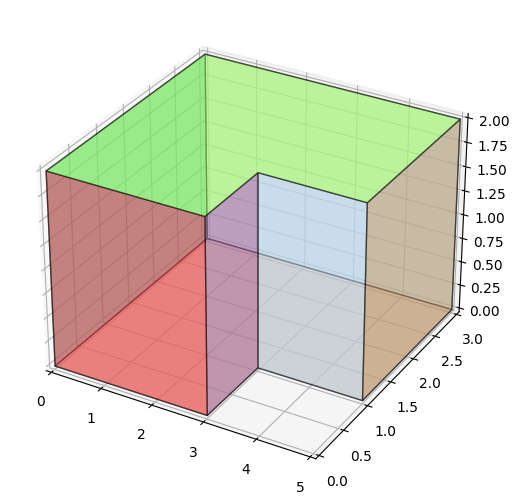

In [3]:
room.extrude(2.)

fig, ax = room.plot()

### 二、添加声源与麦克风

我们可以很方便的通过`add_source`方法给创建的房间模型添加声源。

✨ 另外，我们还可以将`numpy`数组作为声源信号。**说明**：后续使用自己构建的声源数据的时候会用到这个方法。

本脚本使用的音频数据源来自于：[Festvox: US bdl (US male)](http://www.festvox.org/cmu_arctic/dbs_bdl.html)

<class 'int'>
<class 'numpy.ndarray'>


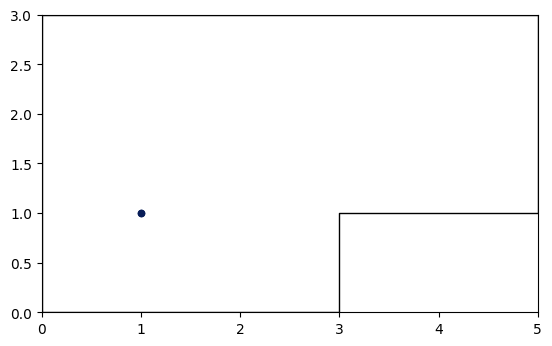

In [4]:
# 使用wavfile.read方法读取arctic_10001.wav音频数据，返回频率fs和信号signal数据
# fs的数据类型为整型int；
# signal的数据类型为numpy.ndarray
fs, signal = wavfile.read("arctic_a0001.wav")
print(type(fs))
print(type(signal))

# 向房间中添加信号源
# 首通过from_corners()方法设置房间的频率属性、ray_tracing、空气吸收率（air_absorption）进行设置，并生成新的2D房间room对象
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, air_absorption=True)
# 使用add_source()方法在[1., 1.]位置添加信号源signal
room.add_source([1.,1.], signal=signal)

# 绘制房间和信号源
fig, ax = room.plot()

同样的，我们可以添加麦克风阵列。

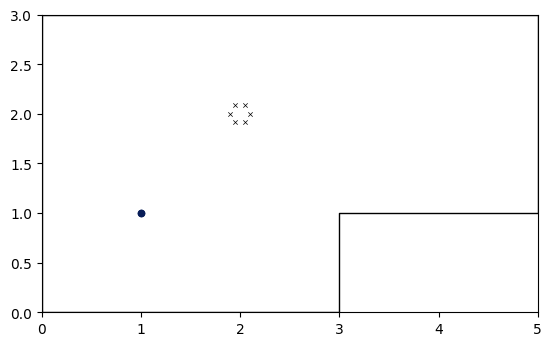

In [5]:
# 圆形麦克风阵列的构建方法：使用circular_2D_array()方法在圆心位置为[2.,2.]的地方构建一个半径radius为0.1，麦克风个数M为6的麦克风圆形阵列。
R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
# 添加麦克风阵列的方法：首先使用MicrophoneArray()类方法构建一个麦克风阵列对象；然后使用add_microphone_array()将构建的麦克风阵列添加到room对象中
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

# 绘制房间与麦克风矩阵
fig, ax = room.plot()

### 三、房间脉冲响应（RIR）生成器与传播仿真

使用ISM（Image Source Model）计算每个麦克风的脉冲响应。通过房间构造器（Room Constructor），我们可以设置ISM的最大ISM阶数和吸收率。

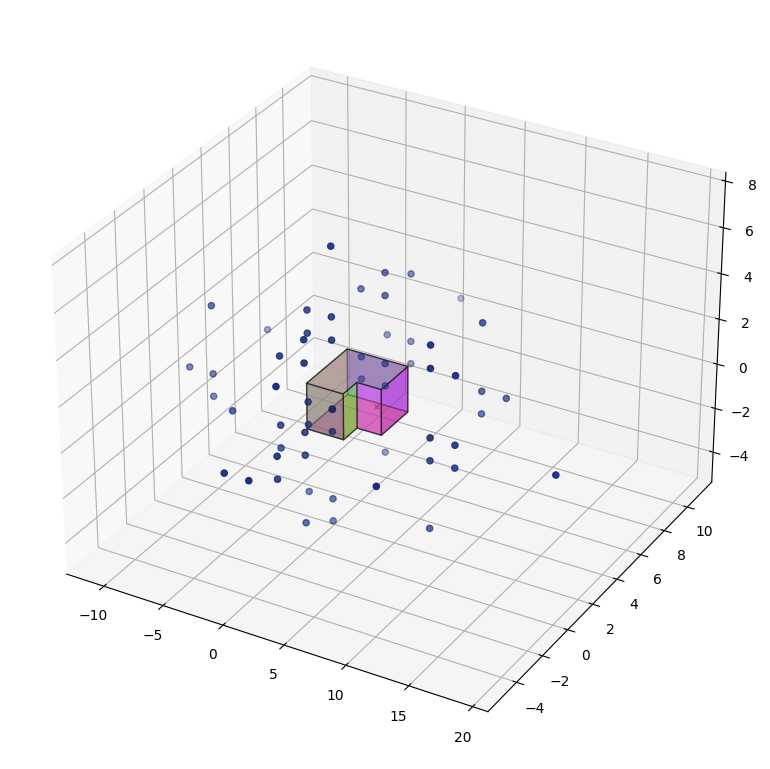

In [6]:
# 指定信号源
fs, signal = wavfile.read("arctic_a0001.wav")

# 设置房间脉冲响应ISM方法的最大阶数max_order，并设置响应的频率、materials、ray_tracing、空气吸收率参数，并实例化一个带有RIR以及相关参数的房间对象
room = pra.Room.from_corners(corners, fs=fs, max_order=3, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True)
# 使用extrude()方法构建3D房间
room.extrude(2., materials=pra.Material(0.2, 0.15))

# 设置ray tracing参数：接收半径（receiver_radius）、n_rays、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 添加信号源
room.add_source([1., 1., 0.5], signal=signal)

# 添加两个麦克风阵列
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])
room.add_microphone(R)

# 使用image_source_model()类方法计算房间room的麦克风脉冲响应
room.image_source_model()

# 对3D多面体房间和image source进行可视化处理
fig, ax = room.plot(img_order=3)
fig.set_size_inches(10.5, 7.5)

当计算了房间的image sources之后，我们就可以是使用room的plot_rir()类方法绘制麦克风（房间脉冲响应）RIR了。

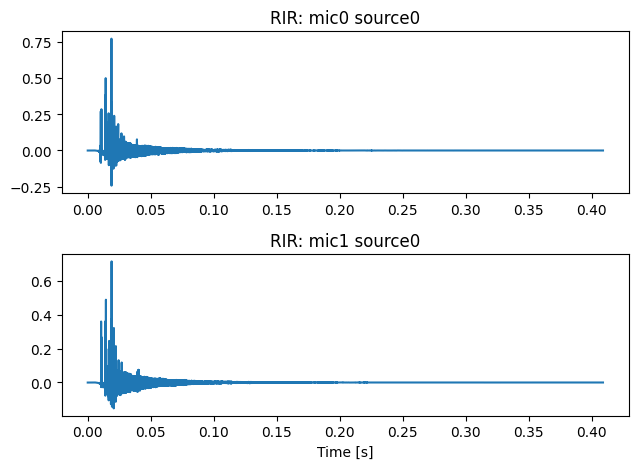

In [7]:
room.plot_rir()
fig = plt.gcf()
# fig.set_size_inches(20, 10)

🌠 <font color="red">**注意：**</font>

其实，用好`pyroomacoutics`软件包的一个关键点在于：<font color="red">**很好的理解每个方法输出数据的结构。**</font>

比如，上面在使用ISM（Image Source Model）计算两个个麦克风的脉冲响应后，代码如下所示：

```python
# 添加两个麦克风阵列
R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])
room.add_microphone(R)

# 使用image_source_model()类方法计算房间room的麦克风脉冲响应
room.image_source_model()
```

此时在房间对象`room`中就有了`rir`类变量，他存储了`room`对象的房间脉冲响应（RIR）结果，需要注意以下几点：

- （1）两个麦克风的房间脉冲是以列表形式存储的，可以通过代码`type(room.rir)`查看其数据类型；
- （2）`room.rir`共包括两个子元素，分别存放两个麦克风的RIR结果，可以通过`len(room.rir)`查看；
- （3）`room.rir`列表的两个元素是以`numpy.ndarray`数据格式存储的，可以通过`type(room.rir[0][0])`和`type(room.rir[1][0])`分别查看。且数据长度均为6545，可以通过`len(room.rir[0][0])`与`len(room.rir[1][0])`分别查看。

In [8]:
# 查看room.rir的数据类型
print("1、麦克风的房间脉冲room.rir的数据存储存储：", type(room.rir))
print("2、麦克风的房间脉冲room.rir包含两个麦克风RIR结果：", len(room.rir))
print("3、room.rir包含的两个RIR结果的数据类型：", type(room.rir[0][0]))
print("4、RIR结果的长度为：", len(room.rir[0][0]))

1、麦克风的房间脉冲room.rir的数据存储存储： <class 'list'>
2、麦克风的房间脉冲room.rir包含两个麦克风RIR结果： 2
3、room.rir包含的两个RIR结果的数据类型： <class 'numpy.ndarray'>
4、RIR结果的长度为： 6545


我们还可以使用`measure_rt60()`方法计算RIR的混响时间（reverberation time）。

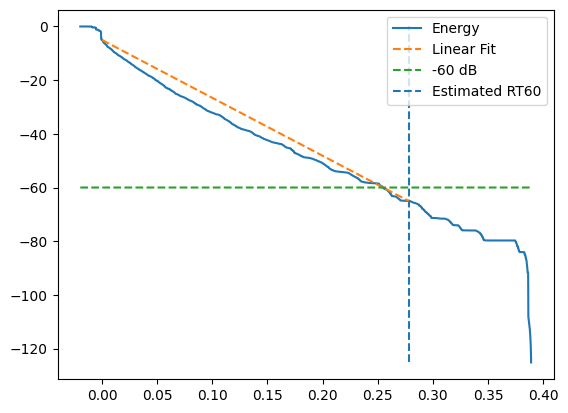

The RT60 is 278 ms


In [9]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

另外，我们可以通过与上面这些脉冲响应进行卷积操作，仿真我们的信号：

In [15]:
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

# signal.shape

Original WAV:


In [11]:
# 指定信号源
# fs, signal = wavfile.read("/home/liang/DataSet/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_51.wav")

# fs, signal = wavfile.read("arctic_a0001.wav")

# IPython.display.Audio(signal, rate=fs)

In [19]:
fs_1, signal_1 = wavfile.read("noise-free-sound-0006.wav")
# fs_2, signal_2 = wavfile.read("noise-free-sound-0015.wav")

print("1", signal_1.shape)
# print("2", signal_2.shape)
IPython.display.Audio(signal_1, rate=fs)

signal_out = signal_1 + 0.1

print(signal_1.shape)
print(signal_out.shape)


1 (124323,)
(124323,)
(124323,)


In [4]:
import pyroomacoustics as pra
import matplotlib.pyplot as plt

corpus = pra.datasets.CMUArcticCorpus(download=True, speaker=['bd1'])

print(corpus)

The dataset contains 0 samples.
Metadata attributes are:


/home/liang/miniconda3/envs/pyannote/lib/python3.8/site-packages/pyroomacoustics/datasets/cmu_arctic.py:152: RuntimeWarning: Some invalid speakers were removed from the list.
  warnings.warn(


The dataset contains 1131 samples.
Metadata attributes are:
  speaker (1) :
      * bdl occurs 1131 times
  tag (1131) :
      * a0001 occurs 1 times
      * a0002 occurs 1 times
      * a0003 occurs 1 times
      ...
      * a0004 occurs 1 times
      * a0005 occurs 1 times
      * a0006 occurs 1 times
  text (1131) :
      * Author of the danger trail, Philip Steels, etc. occurs 1 times
      * Not at this particular case, Tom, apologized Whittemore. occurs 1 times
      * For the twentieth time that evening the two men shook hands. occurs 1 times
      ...
      * Lord, but I'm glad to see you again, Phil. occurs 1 times
      * Will we ever forget it. occurs 1 times
      * God bless 'em, I hope I'll go on seeing them forever. occurs 1 times
  sex (1) :
      * male occurs 1131 times
  lang (1) :
      * US English occurs 1131 times
  accent (1) :
      * US occurs 1131 times
The first 10 / 1131 samples:
bdl (male, US English/US); a0001: Author of the danger trail, Philip Steels, e

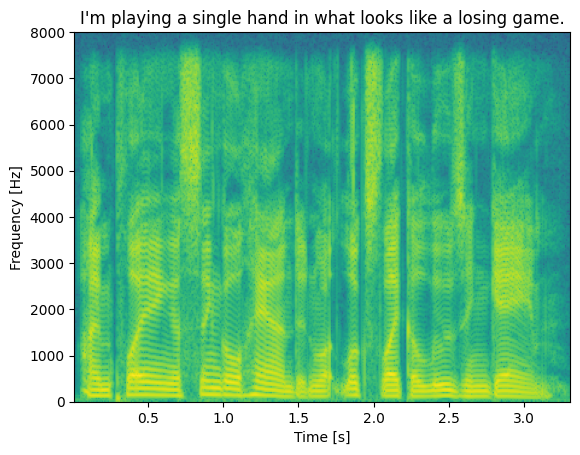

In [11]:
# This example involves the CMU ARCTIC corpus available at
# http://www.festvox.org/cmu_arctic/

import matplotlib.pyplot as plt
import pyroomacoustics as pra

# Here, the corpus for speaker bdl is automatically downloaded
# if it is not available already
corpus = pra.datasets.CMUArcticCorpus(download=True, speaker=['bdl'])

# print dataset info and 10 sentences
print(corpus)
corpus.head(n=10)

# let's extract all samples containing the word 'what'
keyword = 'what'
matches = corpus.filter(text=lambda t : keyword in t)
print('The number of sentences containing "{}": {}'.format(keyword, len(matches)))
for s in matches.sentences:
    print('  *', s)

# if the sounddevice package is available, we can play the sample
matches[0].play()

# show the spectrogram
plt.figure()
matches[0].plot()
plt.show()
